In [ ]:
# in case you don't have these dependencies
!pip install yfinance mplfinance pandas-ta
!pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uni

In [ ]:
# to display figures in high quality svg format
%config InlineBackend.figure_format = 'svg'

### Technical Indicator Dashboard (NVDA Example)

This section builds a compact technical analysis view for a single ticker (here, `NVDA`) using real market data and standard technical indicators. The goal is to show how to turn raw prices into **features** that can later drive trading rules or machine learning models.

#### What the code does

1. **Download and clean price data**

   - Uses `yfinance` to pull daily OHLCV data for `NVDA` from the start of 2024 to today.
   - Normalizes the column names (`open`, `high`, `low`, `close`, `volume`) to keep the DataFrame flat and avoid MultiIndex issues.

2. **Compute classic technical indicators with `pandas_ta`**

   - **Simple Moving Averages (SMA 20 / 50 / 200)**  
     Smooth the price over different lookback windows:
     - 20-day SMA → short-term trend  
     - 50-day SMA → intermediate trend  
     - 200-day SMA → long-term trend / regime  
     Crossovers (e.g., price above or below these lines) are common building blocks for trend-following strategies.

   - **Bollinger Bands (BB)**  
     A 20-period moving average plus/minus a multiple of recent volatility (standard deviation):
     - Upper band ≈ “statistically high” relative to recent prices  
     - Lower band ≈ “statistically low”  
     Touches or breaks of the bands are often used as volatility or mean-reversion signals.

   - **MACD (Moving Average Convergence Divergence)**  
     A trend-following momentum indicator built from two EMAs of price:
     - MACD line vs. signal line crossovers can indicate momentum shifts.  
     - The histogram shows the distance between MACD and signal line, highlighting acceleration or deceleration of trend.

   - **RSI (Relative Strength Index, 14-period)**  
     A bounded oscillator between 0 and 100 that measures recent gains vs. losses:
     - High values (e.g., > 70) are often interpreted as “overbought.”  
     - Low values (e.g., < 30) as “oversold.”  
     RSI is a classic ingredient in mean-reversion and momentum filters.

3. **Merge indicators into a single DataFrame**

   - All indicators are concatenated into the main `data` DataFrame so that each row contains:
     - OHLCV columns  
     - Moving averages (SMA 20 / 50 / 200)  
     - Bollinger Band levels (upper / lower)  
     - MACD line, signal, and histogram  
     - RSI value  

4. **Build a multi-panel chart with `mplfinance`**

   - Uses `mplfinance` to create:
     - A **candlestick chart** with SMA and Bollinger Bands overlaid.  
     - A **MACD panel** underneath the main price chart.  
     - An **RSI panel** at the bottom.  
     - A **volume panel** showing trading activity.

This kind of chart is useful both visually (to develop intuition) and quantitatively: the same time series (SMA, Bollinger Bands, MACD, RSI) can be fed into an algorithmic strategy as features or conditions for entries and exits.

# Nvidia

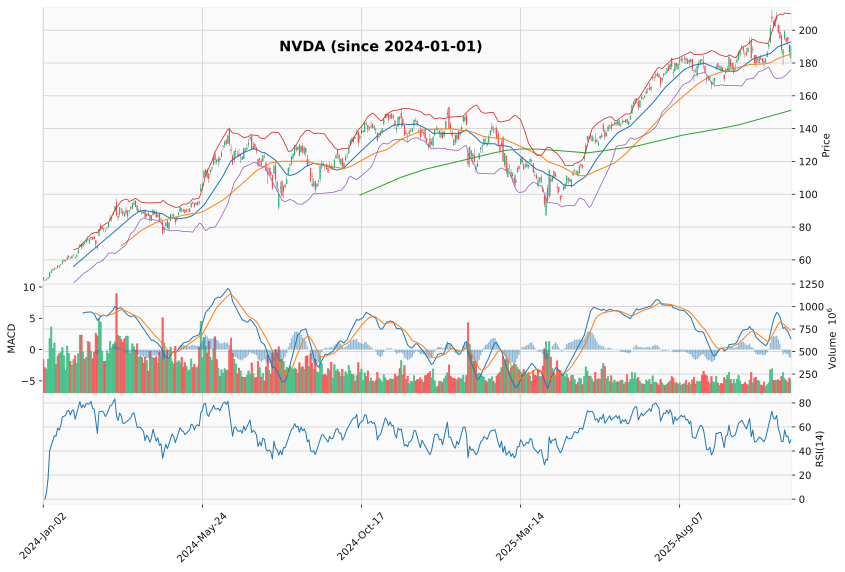

In [ ]:
# pip install -U yfinance mplfinance pandas-ta
import yfinance as yf, mplfinance as mpf, pandas_ta as ta
import pandas as pd, datetime as dt

start_date = dt.datetime(2024,1,1)
end_date   = dt.datetime.now()
ticker     = "NVDA"

# 1) Flat OHLCV (no MultiIndex headaches)
data = yf.Ticker(ticker).history(start=start_date, end=end_date, auto_adjust=True)
data = data.rename(columns=str.lower)  # open, high, low, close, volume

# 2) Indicators (compute as separate objs so we can grab their column names)
sma20  = ta.sma(data["close"], length=20).rename("SMA_20")
sma50  = ta.sma(data["close"], length=50).rename("SMA_50")
sma200 = ta.sma(data["close"], length=200).rename("SMA_200")

bb   = ta.bbands(close=data["close"], length=20, std=2)   # columns vary by version
macd = ta.macd(close=data["close"])                       # columns vary by version
rsi  = ta.rsi(close=data["close"], length=14).rename("RSI_14")

# 3) Merge
data = pd.concat([data, sma20, sma50, sma200, bb, macd, rsi], axis=1)

# 4) Detect BB & MACD actual column names
bb_upper = [c for c in bb.columns if "BBU" in c.upper()][0]
bb_lower = [c for c in bb.columns if "BBL" in c.upper()][0]

macd_cols = list(macd.columns)
macd_line   = [c for c in macd_cols if c.upper().startswith("MACD_") and "H" not in c.upper() and "S" not in c.upper()]
macd_signal = [c for c in macd_cols if "S" in c.upper() and "MACD" in c.upper()]
macd_hist   = [c for c in macd_cols if "H" in c.upper() and "MACD" in c.upper()]
macd_line   = macd_line[0]
macd_signal = macd_signal[0]
macd_hist   = macd_hist[0]

# 5) Build addplots using detected names
apds = [
    mpf.make_addplot(data["SMA_20"],  width=1),
    mpf.make_addplot(data["SMA_50"],  width=1),
    mpf.make_addplot(data["SMA_200"], width=1),
    mpf.make_addplot(data[bb_upper],  width=0.8),
    mpf.make_addplot(data[bb_lower],  width=0.8),

    mpf.make_addplot(data[macd_line],   panel=1, width=1, ylabel="MACD"),
    mpf.make_addplot(data[macd_signal], panel=1, width=1),
    mpf.make_addplot(data[macd_hist],   panel=1, type="bar", alpha=0.5),

    mpf.make_addplot(data["RSI_14"], panel=2, width=1, ylabel="RSI(14)")
]

# 6) mplfinance wants Title-case OHLCV
mpf_data = data.rename(columns={"open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"})

mpf.plot(
    mpf_data,
    type="candle",
    style="yahoo",
    title=f"{ticker} (since {start_date.date()})",
    addplot=apds,
    volume=True,              # keep this; if Volume is present it'll add a panel
    tight_layout=True,
    figsize=(12,8),
    show_nontrading=False
)


**A few more examples!**

# Amazon

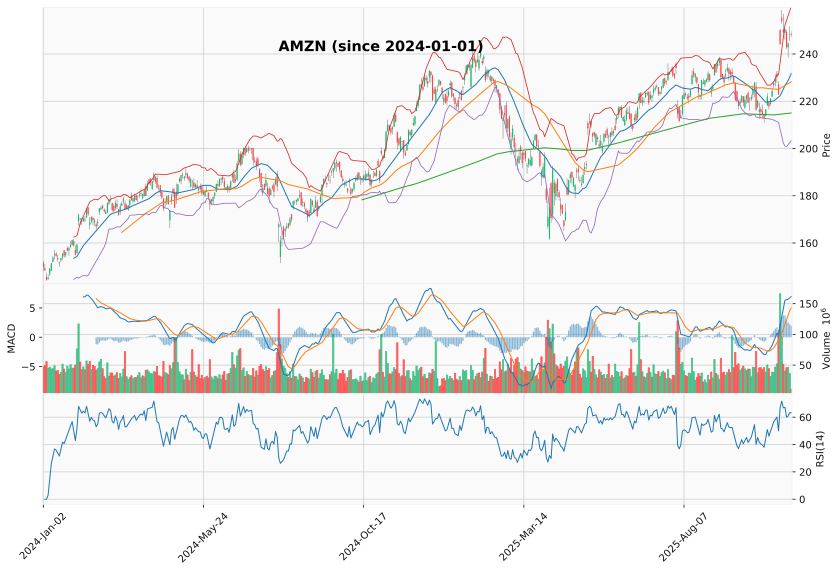

In [ ]:
start_date = dt.datetime(2024,1,1)
end_date   = dt.datetime.now()
ticker     = "AMZN"

# 1) Flat OHLCV (no MultiIndex headaches)
data = yf.Ticker(ticker).history(start=start_date, end=end_date, auto_adjust=True)
data = data.rename(columns=str.lower)  # open, high, low, close, volume

# 2) Indicators (compute as separate objs so we can grab their column names)
sma20  = ta.sma(data["close"], length=20).rename("SMA_20")
sma50  = ta.sma(data["close"], length=50).rename("SMA_50")
sma200 = ta.sma(data["close"], length=200).rename("SMA_200")

bb   = ta.bbands(close=data["close"], length=20, std=2)   # columns vary by version
macd = ta.macd(close=data["close"])                       # columns vary by version
rsi  = ta.rsi(close=data["close"], length=14).rename("RSI_14")

# 3) Merge
data = pd.concat([data, sma20, sma50, sma200, bb, macd, rsi], axis=1)

# 4) Detect BB & MACD actual column names
bb_upper = [c for c in bb.columns if "BBU" in c.upper()][0]
bb_lower = [c for c in bb.columns if "BBL" in c.upper()][0]

macd_cols = list(macd.columns)
macd_line   = [c for c in macd_cols if c.upper().startswith("MACD_") and "H" not in c.upper() and "S" not in c.upper()]
macd_signal = [c for c in macd_cols if "S" in c.upper() and "MACD" in c.upper()]
macd_hist   = [c for c in macd_cols if "H" in c.upper() and "MACD" in c.upper()]
macd_line   = macd_line[0]
macd_signal = macd_signal[0]
macd_hist   = macd_hist[0]

# 5) Build addplots using detected names
apds = [
    mpf.make_addplot(data["SMA_20"],  width=1),
    mpf.make_addplot(data["SMA_50"],  width=1),
    mpf.make_addplot(data["SMA_200"], width=1),
    mpf.make_addplot(data[bb_upper],  width=0.8),
    mpf.make_addplot(data[bb_lower],  width=0.8),

    mpf.make_addplot(data[macd_line],   panel=1, width=1, ylabel="MACD"),
    mpf.make_addplot(data[macd_signal], panel=1, width=1),
    mpf.make_addplot(data[macd_hist],   panel=1, type="bar", alpha=0.5),

    mpf.make_addplot(data["RSI_14"], panel=2, width=1, ylabel="RSI(14)")
]

# 6) mplfinance wants Title-case OHLCV
mpf_data = data.rename(columns={"open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"})

mpf.plot(
    mpf_data,
    type="candle",
    style="yahoo",
    title=f"{ticker} (since {start_date.date()})",
    addplot=apds,
    volume=True,              # keep this; if Volume is present it'll add a panel
    tight_layout=True,
    figsize=(12,8),
    show_nontrading=False
)


# Tesla

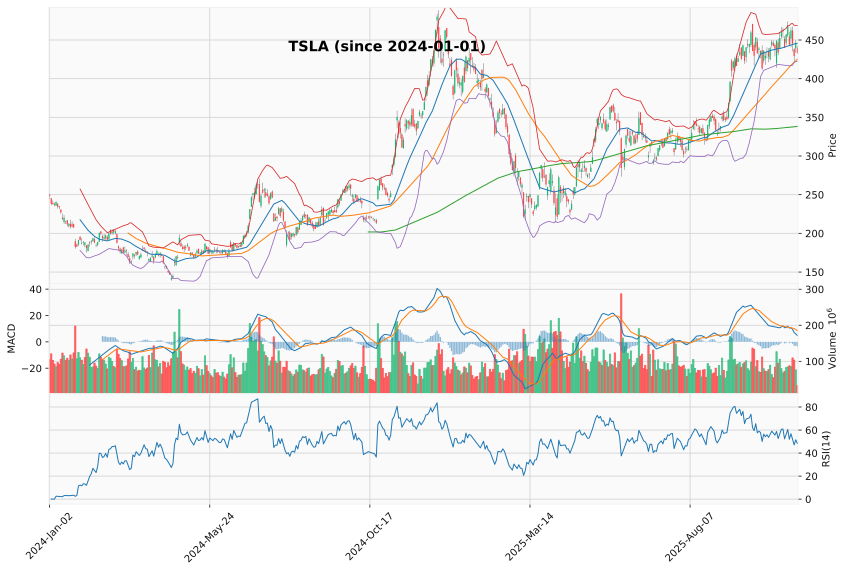

In [ ]:
start_date = dt.datetime(2024,1,1)
end_date   = dt.datetime.now()
ticker     = "TSLA"

# 1) Flat OHLCV (no MultiIndex headaches)
data = yf.Ticker(ticker).history(start=start_date, end=end_date, auto_adjust=True)
data = data.rename(columns=str.lower)  # open, high, low, close, volume

# 2) Indicators (compute as separate objs so we can grab their column names)
sma20  = ta.sma(data["close"], length=20).rename("SMA_20")
sma50  = ta.sma(data["close"], length=50).rename("SMA_50")
sma200 = ta.sma(data["close"], length=200).rename("SMA_200")

bb   = ta.bbands(close=data["close"], length=20, std=2)   # columns vary by version
macd = ta.macd(close=data["close"])                       # columns vary by version
rsi  = ta.rsi(close=data["close"], length=14).rename("RSI_14")

# 3) Merge
data = pd.concat([data, sma20, sma50, sma200, bb, macd, rsi], axis=1)

# 4) Detect BB & MACD actual column names
bb_upper = [c for c in bb.columns if "BBU" in c.upper()][0]
bb_lower = [c for c in bb.columns if "BBL" in c.upper()][0]

macd_cols = list(macd.columns)
macd_line   = [c for c in macd_cols if c.upper().startswith("MACD_") and "H" not in c.upper() and "S" not in c.upper()]
macd_signal = [c for c in macd_cols if "S" in c.upper() and "MACD" in c.upper()]
macd_hist   = [c for c in macd_cols if "H" in c.upper() and "MACD" in c.upper()]
macd_line   = macd_line[0]
macd_signal = macd_signal[0]
macd_hist   = macd_hist[0]

# 5) Build addplots using detected names
apds = [
    mpf.make_addplot(data["SMA_20"],  width=1),
    mpf.make_addplot(data["SMA_50"],  width=1),
    mpf.make_addplot(data["SMA_200"], width=1),
    mpf.make_addplot(data[bb_upper],  width=0.8),
    mpf.make_addplot(data[bb_lower],  width=0.8),

    mpf.make_addplot(data[macd_line],   panel=1, width=1, ylabel="MACD"),
    mpf.make_addplot(data[macd_signal], panel=1, width=1),
    mpf.make_addplot(data[macd_hist],   panel=1, type="bar", alpha=0.5),

    mpf.make_addplot(data["RSI_14"], panel=2, width=1, ylabel="RSI(14)")
]

# 6) mplfinance wants Title-case OHLCV
mpf_data = data.rename(columns={"open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"})

mpf.plot(
    mpf_data,
    type="candle",
    style="yahoo",
    title=f"{ticker} (since {start_date.date()})",
    addplot=apds,
    volume=True,              # keep this; if Volume is present it'll add a panel
    tight_layout=True,
    figsize=(12,8),
    show_nontrading=False
)


# Apple

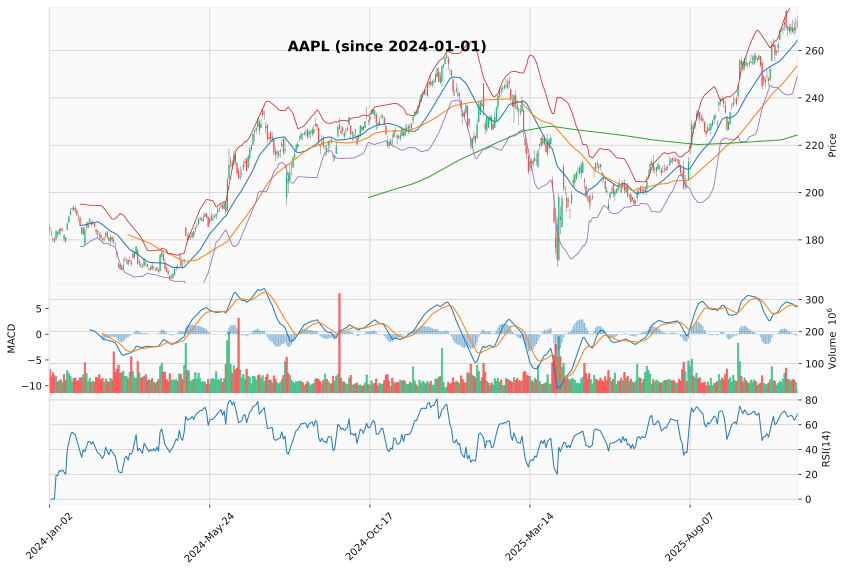

In [ ]:
start_date = dt.datetime(2024,1,1)
end_date   = dt.datetime.now()
ticker     = "AAPL"

# 1) Flat OHLCV (no MultiIndex headaches)
data = yf.Ticker(ticker).history(start=start_date, end=end_date, auto_adjust=True)
data = data.rename(columns=str.lower)  # open, high, low, close, volume

# 2) Indicators (compute as separate objs so we can grab their column names)
sma20  = ta.sma(data["close"], length=20).rename("SMA_20")
sma50  = ta.sma(data["close"], length=50).rename("SMA_50")
sma200 = ta.sma(data["close"], length=200).rename("SMA_200")

bb   = ta.bbands(close=data["close"], length=20, std=2)   # columns vary by version
macd = ta.macd(close=data["close"])                       # columns vary by version
rsi  = ta.rsi(close=data["close"], length=14).rename("RSI_14")

# 3) Merge
data = pd.concat([data, sma20, sma50, sma200, bb, macd, rsi], axis=1)

# 4) Detect BB & MACD actual column names
bb_upper = [c for c in bb.columns if "BBU" in c.upper()][0]
bb_lower = [c for c in bb.columns if "BBL" in c.upper()][0]

macd_cols = list(macd.columns)
macd_line   = [c for c in macd_cols if c.upper().startswith("MACD_") and "H" not in c.upper() and "S" not in c.upper()]
macd_signal = [c for c in macd_cols if "S" in c.upper() and "MACD" in c.upper()]
macd_hist   = [c for c in macd_cols if "H" in c.upper() and "MACD" in c.upper()]
macd_line   = macd_line[0]
macd_signal = macd_signal[0]
macd_hist   = macd_hist[0]

# 5) Build addplots using detected names
apds = [
    mpf.make_addplot(data["SMA_20"],  width=1),
    mpf.make_addplot(data["SMA_50"],  width=1),
    mpf.make_addplot(data["SMA_200"], width=1),
    mpf.make_addplot(data[bb_upper],  width=0.8),
    mpf.make_addplot(data[bb_lower],  width=0.8),

    mpf.make_addplot(data[macd_line],   panel=1, width=1, ylabel="MACD"),
    mpf.make_addplot(data[macd_signal], panel=1, width=1),
    mpf.make_addplot(data[macd_hist],   panel=1, type="bar", alpha=0.5),

    mpf.make_addplot(data["RSI_14"], panel=2, width=1, ylabel="RSI(14)")
]

# 6) mplfinance wants Title-case OHLCV
mpf_data = data.rename(columns={"open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"})

mpf.plot(
    mpf_data,
    type="candle",
    style="yahoo",
    title=f"{ticker} (since {start_date.date()})",
    addplot=apds,
    volume=True,              # keep this; if Volume is present it'll add a panel
    tight_layout=True,
    figsize=(12,8),
    show_nontrading=False
)


# Mathematical Modeling

## Single exact Geometric Brownian Motion

### Geometric Brownian Motion (GBM) single simulated path

A lot of quantitative finance models, including Black–Scholes, assume that asset prices follow a **Geometric Brownian Motion (GBM)**. In continuous time, GBM is defined by the stochastic differential equation

$dS_t = \mu S_t \, dt + \sigma S_t \, dW_t,$

where:
- $S_t$ is the asset price at time $ t $,
- $\mu $ is the drift (expected return),
- $ \sigma $ is the volatility,
- $ W_t $ is a standard Wiener process (Brownian motion).

In this code cell:

- `S0 = 100` is the initial asset price  $S_0$.
- `mu = 0.05` is the annualized drift.
- `sigma = 0.2` is the annualized volatility.
- `T = 1.0` is the time horizon in years.
- `N = 1000` is the number of time steps, so `dt = T/N` is the time step size.

We first simulate a Brownian motion path $W_t $ by drawing `N` standard normal increments and accumulating them. Then we use the **closed-form solution** of GBM,

$S_t = S_0 \exp\left( \left(\mu - \tfrac{1}{2}\sigma^2\right)t + \sigma W_t \right),$

to compute the asset price at each time point. Finally, we plot a **single sample path** of $S_t $ over the interval $[0, T]$.

This example illustrates how randomness in $ W_t $ translates into a random trajectory for the asset price, even when the drift and volatility parameters are fixed.


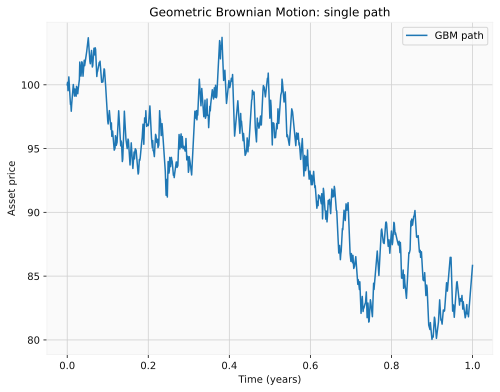

In [ ]:
# %config InlineBackend.figure_format = 'svg'   # optional: crisp SVG in Jupyter
import numpy as np
import matplotlib.pyplot as plt

S0, mu, sigma, T = 100, 0.05, 0.2, 1.0
N = 1000
dt = T / N
rng = np.random.default_rng(42)

t = np.linspace(0.0, T, N+1)                 # N+1 points including t=0
dW = rng.standard_normal(N) * np.sqrt(dt)    # N increments
W  = np.concatenate(([0.0], np.cumsum(dW)))  # Wiener path with W(0)=0

S = S0 * np.exp((mu - 0.5*sigma**2)*t + sigma*W)  # exact solution

plt.figure(figsize=(8,6))
plt.plot(t, S, label="GBM path")
plt.title("Geometric Brownian Motion: single path")
plt.xlabel("Time (years)")
plt.ylabel("Asset price")
plt.grid(True)
plt.legend()
plt.show()

## Monte Carlo: many paths + mean and 5-95% band

### Geometric Brownian Motion - Monte Carlo ensemble

The previous example showed a **single** GBM path. Here, we generate an **ensemble** of simulated paths and compare their empirical statistics to the analytical solution.

We still assume that the asset price $S_t$ follows Geometric Brownian Motion:

$
dS_t = \mu S_t \, dt + \sigma S_t \, dW_t,
$

with closed-form solution

$
S_t = S_0 \exp\left( \left(\mu - \tfrac{1}{2}\sigma^2\right)t + \sigma W_t \right),
$

where $W_t$ is standard Brownian motion.

#### What the code does

- **Model parameters**

  - `S0 = 100`: initial asset price \(S_0\)  
  - `mu = 0.05`: drift  
  - `sigma = 0.2`: volatility  
  - `T = 1.0`: time horizon (in years)  
  - `N = 1000`: number of time steps  
  - `M = 2000`: number of simulated paths

- **Simulate Brownian motion for many paths**

  - Draw `M × N` standard normal increments scaled by $\sqrt{\Delta t}$.
  - Take a cumulative sum along the time axis and prepend zeros to enforce $W_0 = 0$.
  - Result: `W` has shape `(M, N+1)` and represents $M$ Brownian motion paths over $[0, T]$.

- **Compute GBM paths exactly**

  - Use the vectorized closed-form formula
    $
    S_t = S_0 \exp\left( (\mu - \tfrac{1}{2}\sigma^2)t + \sigma W_t \right)
    $
    to get an `(M, N+1)` array `S` of simulated prices.

- **Compare Monte Carlo statistics to analytics**

  - The **analytic mean** of GBM is
    $
    \mathbb{E}[S_t] = S_0 e^{\mu t}.
    $
    This is computed as `S_mean_analytic` and plotted as a dashed line.
  - The **Monte Carlo mean** `S.mean(0)` is plotted as a solid line. As $M$ grows, this empirical mean should track the analytic curve closely.

- **Quantile band**

  - We compute the 5th and 95th percentiles across the $M$ paths at each time $t$.
  - The shaded **5-95% band** visualizes the dispersion of the simulated price distribution over time.

Overall, this plot shows:

- A handful of individual GBM trajectories (sample paths).
- The Monte Carlo mean converging toward the analytical expectation $ \mathbb{E}[S_t] $.
- A percentile band that illustrates how uncertainty (driven by volatility $\sigma$) widens the range of plausible prices as time increases.

This kind of Monte Carlo ensemble is a standard building block for pricing, risk analysis, and validating that a numerical implementation matches the underlying mathematical model.


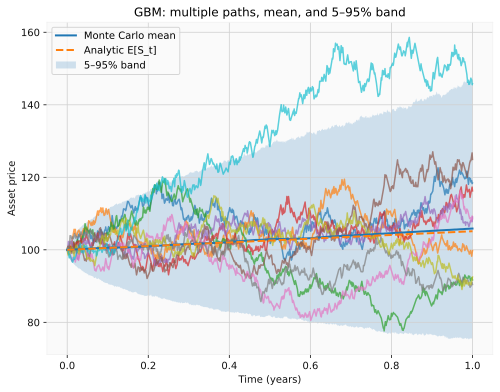

In [ ]:
# %config InlineBackend.figure_format = 'svg'   # optional: SVG
import numpy as np
import matplotlib.pyplot as plt

S0, mu, sigma, T = 100, 0.05, 0.2, 1.0
N, M = 1000, 2000     # N steps, M paths
dt = T / N
rng = np.random.default_rng(123)

t  = np.linspace(0.0, T, N+1)
dW = rng.standard_normal((M, N)) * np.sqrt(dt)
W  = np.concatenate([np.zeros((M,1)), np.cumsum(dW, axis=1)], axis=1)

# Exact solution pathwise
drift = (mu - 0.5*sigma**2) * t
S = S0 * np.exp(drift + sigma * W)           # shape (M, N+1)

# Analytics for mean path: E[S_t] = S0 * exp(mu t)
S_mean_analytic = S0 * np.exp(mu * t)

# Plot a few sample paths + statistics
plt.figure(figsize=(8,6))
for i in range(10):                          # show a handful of paths
    plt.plot(t, S[i], alpha=0.7)

plt.plot(t, S.mean(0), lw=2, label="Monte Carlo mean")
plt.plot(t, S_mean_analytic, lw=2, linestyle="--", label="Analytic E[S_t]")

p5, p95 = np.percentile(S, [5,95], axis=0)
plt.fill_between(t, p5, p95, alpha=0.2, label="5–95% band")

plt.title("GBM: multiple paths, mean, and 5–95% band")
plt.xlabel("Time (years)")
plt.ylabel("Asset price")
plt.grid(True)
plt.legend()
plt.show()

# Data Driven Modeling

## Multi-asset returns, correlation, and cumulative performance

This block of code pulls historical price data for a **portfolio of large-cap US tech names**:

- `AAPL`, `MSFT`, `GOOGL`, `AMZN`, `TSLA`

and then walks through a standard quantitative workflow:

1. **Download and clean price data**

   - Uses `yfinance` to download daily, auto-adjusted OHLCV data from 2015 to early 2026.
   - Extracts the **adjusted close** prices into a clean `prices` DataFrame (one column per ticker).
   - Aligns everything to a **business-day calendar** and forward-fills small gaps so all series are on the same timeline.  
     This makes later calculations like returns, correlations, and portfolio backtests well-defined.

2. **Compute log returns**

   - Daily log returns are computed as $r_{t} = \log\left(\frac{P_t}{P_{t-1}}\right)$
   - Log returns are convenient because they:
     - Add over time: total log return is the sum of daily log returns.
     - Are symmetric and easier to work with in many models.

3. **Correlation matrix (comovement between assets)**

   - The code builds a **correlation matrix** of daily log returns:
     ```python
     C = returns.corr()
     ```
   - A heatmap visualizes:
     - High positive correlation (close to +1): assets tend to move together.
     - Negative correlation (close to -1): assets tend to move in opposite directions.
     - Low correlation (near 0): movements are relatively independent.
   - This is directly related to **diversification**: combining assets that are not perfectly correlated can reduce portfolio volatility.

4. **Cumulative gross returns (growth of \$1)**

   - For log returns, the **wealth process** for an asset is: $\text{Wealth}_t = \exp\left(\sum_{s \le t} r_s\right).$
   - The code uses:
     ```python
     cum = np.exp(returns.cumsum())
     ```
     which gives the **cumulative gross return** (growth of \$1 invested at the start) for each asset.
   - Plotting these curves shows:
     - How each stock has grown over the sample period.
     - Differences in **trend, volatility, and drawdowns** across assets.

This combination — **multi-asset price history → daily log returns → correlation → cumulative performance** — is a foundational pattern in algorithmic trading and portfolio research. You can build on top of this to:

- Test portfolio constructions and hedging ideas.
- Identify clusters of highly correlated names.
- Compare strategy performance to simple “buy-and-hold” baselines for each asset.


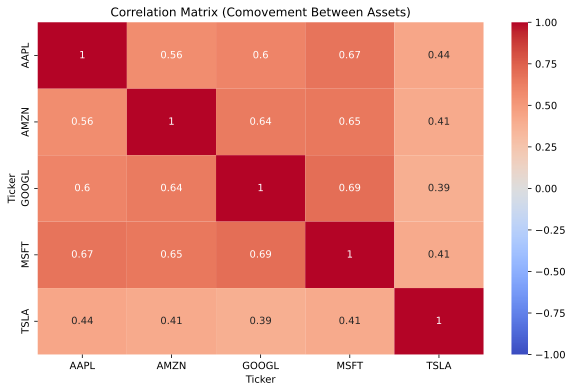

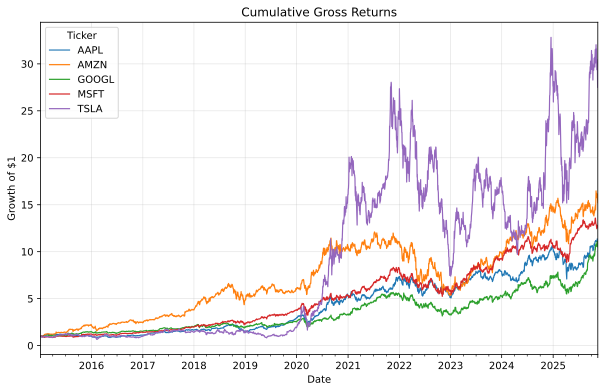

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

raw = yf.download(
    tickers,
    start='2015-01-01',
    end='2026-01-01',
    auto_adjust=True,
    progress=False
)

# --- Get adjusted close prices correctly ---
if isinstance(raw.columns, pd.MultiIndex):
    # yfinance: level 0 = field name, level 1 = ticker
    # This gives a DataFrame with columns = tickers
    prices = raw.xs('Close', axis=1, level=0).copy()
    # or equivalently: prices = raw['Close'].copy()
else:
    # Single-index fallback (e.g. single ticker)
    close_cols = [c for c in raw.columns if 'close' in c.lower()]
    prices = raw[close_cols].copy()

# Align to business days and forward-fill tiny gaps
prices = prices.asfreq('B').ffill()

# Log returns
returns = np.log(prices / prices.shift(1)).dropna(how='all')

# Correlation matrix
C = returns.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(C, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Comovement Between Assets)')
plt.show()

# --- Cumulative returns: small conceptual fix ---
# For log returns r_log, wealth process is exp(cumsum(r_log))
cum = np.exp(returns.cumsum())
cum.plot(figsize=(10, 6), lw=1.2, title='Cumulative Gross Returns')
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.grid(True, alpha=0.3)
plt.show()